In [1]:
!pip install dice_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.6 MB/s eta 0:00:00


In [2]:
import re
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb

import shap
from lime import lime_tabular
import dice_ml

In [3]:
INPUT_ROOT = "/kaggle/input/df2026"

TRAIN_FRESH = f"{INPUT_ROOT}/data_cred/train_fresh.csv"
TRAIN_SENIOR = f"{INPUT_ROOT}/data_cred/train_senior.csv"

VAL_FRESH = f"{INPUT_ROOT}/data_cred/val_fresh.csv"
VAL_SENIOR = f"{INPUT_ROOT}/data_cred/val_senior.csv"

DT_FRESH = f"{INPUT_ROOT}/model/decision_tree_fresher.joblib"
DT_SENIOR = f"{INPUT_ROOT}/model/decision_tree_senior.joblib"

RF_FRESH = f"{INPUT_ROOT}/model/random_forest_fresher.joblib"
RF_SENIOR = f"{INPUT_ROOT}/model/random_forest_senior.joblib"

XGB_FRESH = f"{INPUT_ROOT}/model/xgboost_fresher.json"
XGB_SENIOR = f"{INPUT_ROOT}/model/xgboost_senior.json"

LGB_FRESH = f"{INPUT_ROOT}/model/lgbm_fresher.txt"
LGB_SENIOR = f"{INPUT_ROOT}/model/lgbm_senior.txt"

In [4]:
feats_senior = [
    "TC_DANGKY", "SEMESTER_INDEX", "SV_NAM_THU",
    "LAST_GPA", "LAST_FAIL", "LAST_PASS_RATIO",
    "R2_AVG_GPA", "R2_SUM_FAIL", "R2_PASS_RATE",
    "R3_AVG_GPA", "R3_SUM_FAIL",
    "PRESSURE_VS_R2", "PRESSURE_VS_R3", "OVERLOAD_R3",
    "FAIL_TREND_R2", "GPA_TREND_R2",
    "TOTAL_EARNED", "HIST_AVG_GPA",
    "HIST_MAX_PASSED",  
    "HIST_MAX_GPA", 
    "HIST_STD_GPA",    
    "OVERLOAD_VS_MAX"
]

feats_fresh = [
    "TC_DANGKY", "SEMESTER_INDEX", 
    "PTXT", "TOHOP_XT",
    "DIEM_TRUNGTUYEN", "DIEM_CHUAN", 
    "SCORE_GAP", "ENTRY_RANK", "BENCHMARK_TIER",
    "Z_SCORE", "GAP_RATIO",
    "LAST_GPA", "LAST_FAIL", "LAST_PASS_RATIO",
    "PRESSURE_VS_R2" 
]

In [5]:
def load_model(model_path):
    print(f"Load model: {model_path.split('/')[-1]}")
    if model_path.endswith('.joblib'):
        model = joblib.load(model_path)
    elif model_path.endswith('.json'):
        model = xgb.XGBRegressor()
        model.load_model(model_path)
    elif model_path.endswith('.txt'):
        model = lgb.Booster(model_file=model_path)
    else:
        raise ValueError("Định dạng model không hỗ trợ (.joblib, .json, .txt)")

    return model

In [6]:
def SHAP(model_path, data_path, feats, target_col="TC_HOANTHANH", top_n=7):
    df = pd.read_csv(data_path)
    X = df[feats]
    y_true = df[target_col].values

    model = load_model(model_path)

    if isinstance(model, lgb.Booster):
        y_pred = model.predict(X)
    else:
        y_pred = model.predict(X).flatten()
    
    errors = np.abs(y_true - y_pred)
    df_res = df.copy()
    df_res['pred'] = y_pred
    df_res['abs_error'] = errors

    n_total = len(df)
    n_sample = max(1, n_total // 10)
    idx_sorted = errors.argsort()
    
    selected_indices = np.concatenate([
        idx_sorted[:n_sample], 
        idx_sorted[(n_total // 2) - (n_sample // 2) : (n_total // 2) + (n_sample // 2)], # Median
        idx_sorted[-n_sample:]
    ])
    
    X_subset = X.iloc[selected_indices]
    y_true_subset = y_true[selected_indices]
    
    try:
        booster = model.get_booster() if hasattr(model, 'get_booster') else model
        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(X_subset)
        expected_value = explainer.expected_value
        method = "Tree"
    except Exception as e:
        background_data = shap.kmeans(X, 10)
        explainer = shap.KernelExplainer(model.predict if not isinstance(model, lgb.Booster) else model.predict, background_data)
        shap_values = explainer.shap_values(X_subset, nsamples=500)
        expected_value = explainer.expected_value
        method = "Kernel"

    if isinstance(shap_values, list): 
        shap_values = shap_values[0]
    if len(shap_values.shape) == 3: 
        shap_values = shap_values.mean(axis=2)
    if isinstance(expected_value, (list, np.ndarray)): 
        expected_value = expected_value[0]

    exp = shap.Explanation(
        values=shap_values.astype(float),
        base_values=float(expected_value),
        data=X_subset.values,
        feature_names=feats
    )

    print(f"\n=== GLOBAL IMPACT ===")
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(exp, max_display=top_n, show=False)
    plt.show()

    case_pos = {
        "BEST CASE": 0,
        "MEDIAN CASE": n_sample + (n_sample // 2),
        "WORST CASE": len(selected_indices) - 1
    }

    print("\n=== REPRESENTATIVE SAMPLES ===")
    for label, pos in case_pos.items():
        real_idx = selected_indices[pos]
        mssv = df.iloc[real_idx]['MA_SO_SV']
        print(f"\n{label} | MSSV: {mssv} | True: {y_true_subset[pos]:.2f} | Pred: {y_pred[selected_indices[pos]]:.2f}")
        plt.figure()
        shap.plots.waterfall(exp[pos], max_display=top_n, show=False)
        plt.title(f"{label} - MSSV: {mssv}")
        plt.show()
    

    print("\n=== CONTRASTIVE ANALYSIS ===")
    worst_idx_sub = len(selected_indices) - 1
    distances = np.linalg.norm(X_subset.iloc[:n_sample].values - X_subset.iloc[worst_idx_sub].values, axis=1)
    closest_best_pos = np.argmin(distances)
    
    mssv_worst = df.iloc[selected_indices[worst_idx_sub]]['MA_SO_SV']
    mssv_best = df.iloc[selected_indices[closest_best_pos]]['MA_SO_SV']
    
    diff_exp = shap.Explanation(
        values=shap_values[worst_idx_sub] - shap_values[closest_best_pos],
        base_values=0,
        data=X_subset.iloc[worst_idx_sub] - X_subset.iloc[closest_best_pos],
        feature_names=feats
    )
    plt.figure()
    shap.plots.bar(diff_exp, max_display=top_n, show=False)
    plt.title(f"Contrastive: {mssv_worst} vs {mssv_best}")
    plt.show()

    return df_res, exp

Load model: lgbm_fresher.txt

=== GLOBAL IMPACT ===


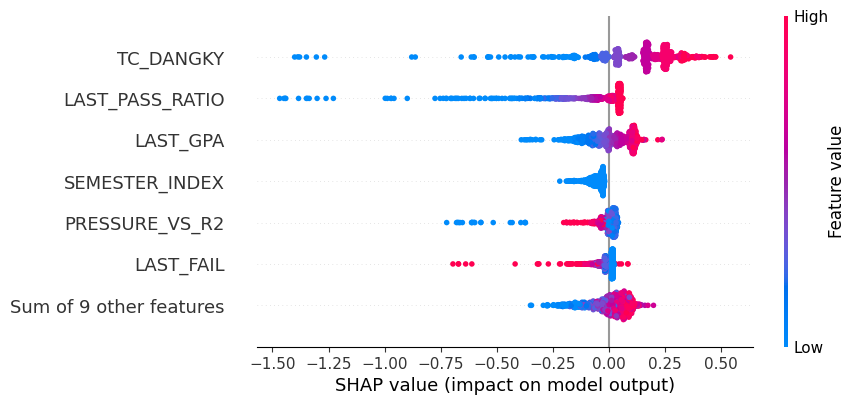


=== REPRESENTATIVE SAMPLES ===

BEST CASE | MSSV: c531f1923c83 | True: 19.00 | Pred: 19.00


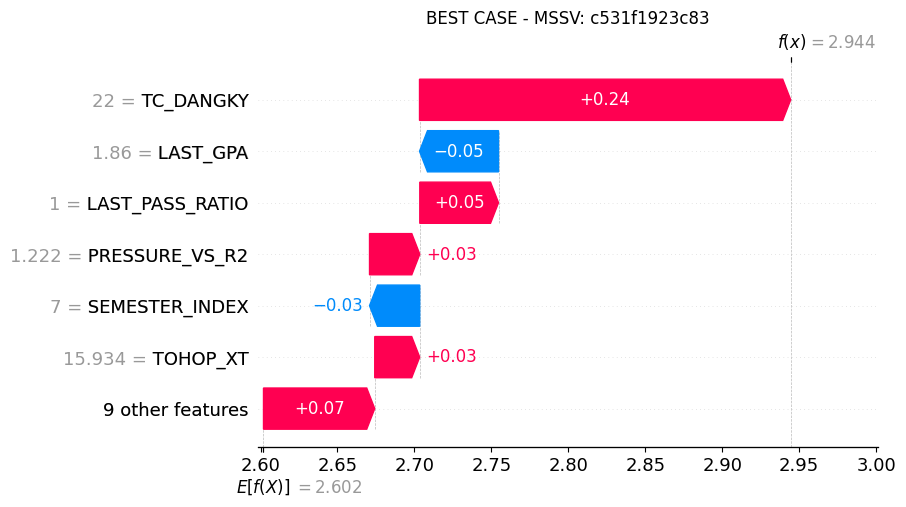


MEDIAN CASE | MSSV: f9d085ec1b49 | True: 19.00 | Pred: 21.20


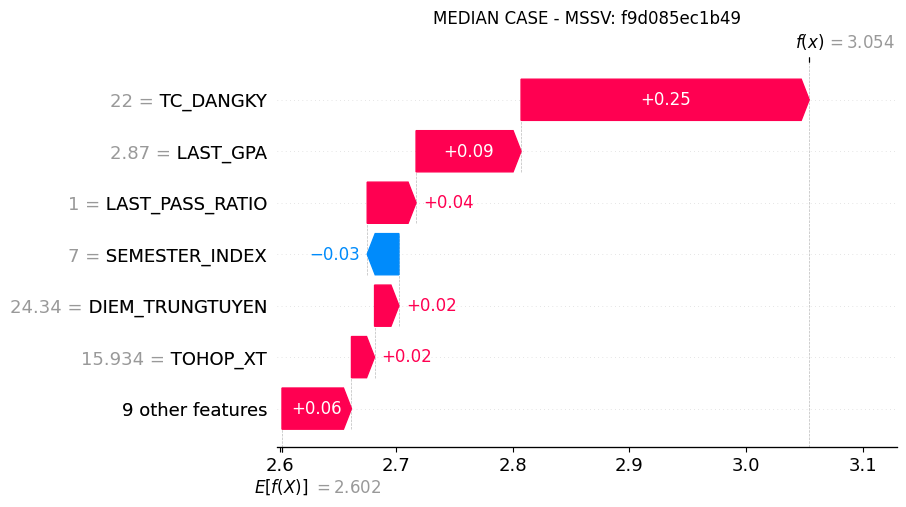


WORST CASE | MSSV: 88e963c787f7 | True: 0.00 | Pred: 17.76


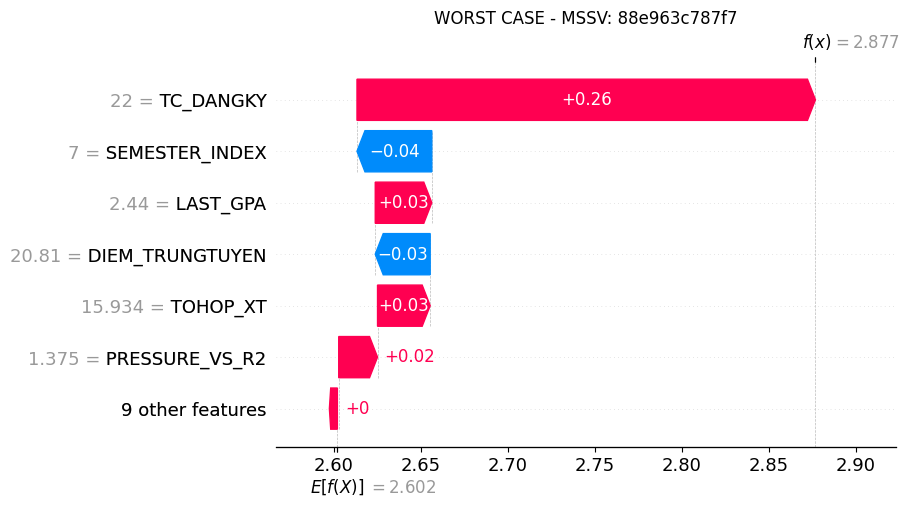


=== CONTRASTIVE ANALYSIS ===


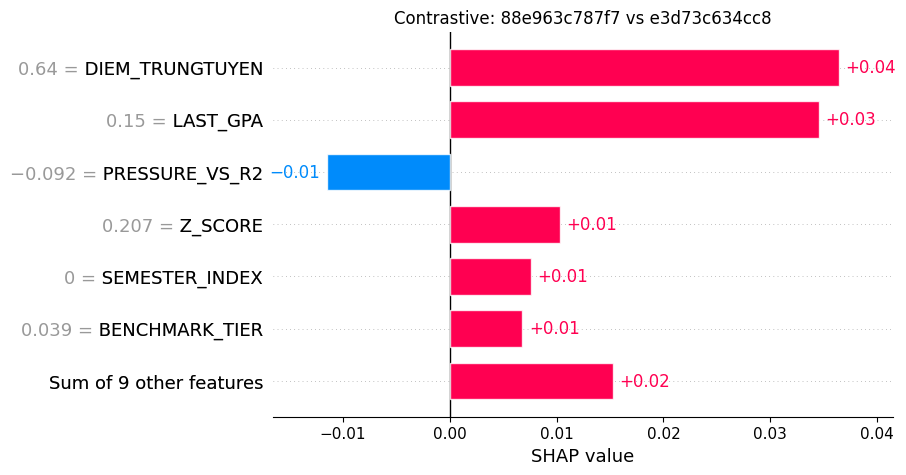

In [7]:
df_res_fresh, exp_fresh = SHAP(LGB_FRESH, VAL_FRESH, feats_fresh)

Load model: lgbm_senior.txt

=== GLOBAL IMPACT ===


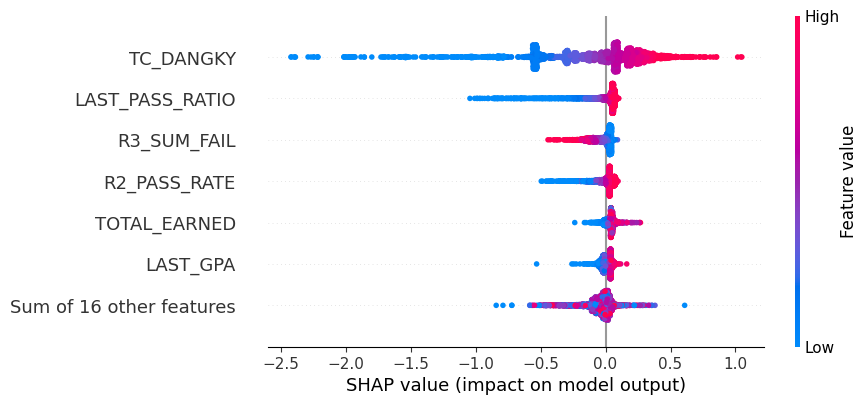


=== REPRESENTATIVE SAMPLES ===

BEST CASE | MSSV: cc925573751d | True: 10.00 | Pred: 10.00


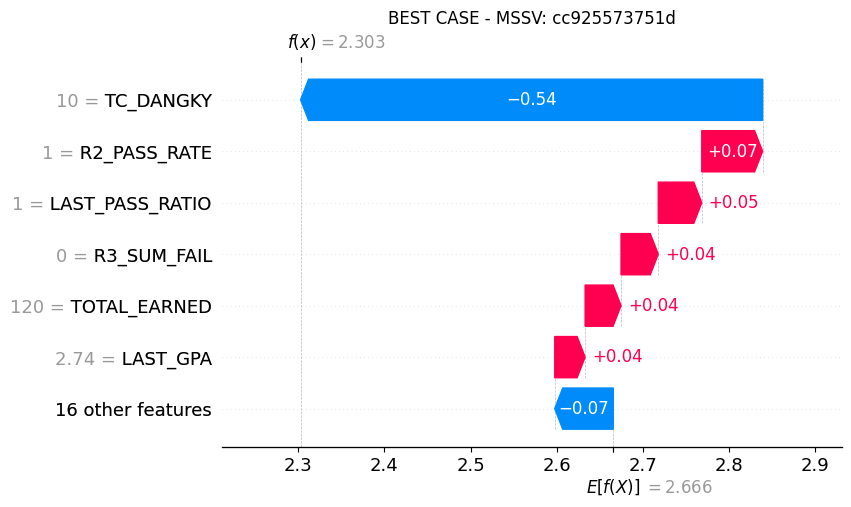


MEDIAN CASE | MSSV: c574dbb4af53 | True: 6.00 | Pred: 7.45


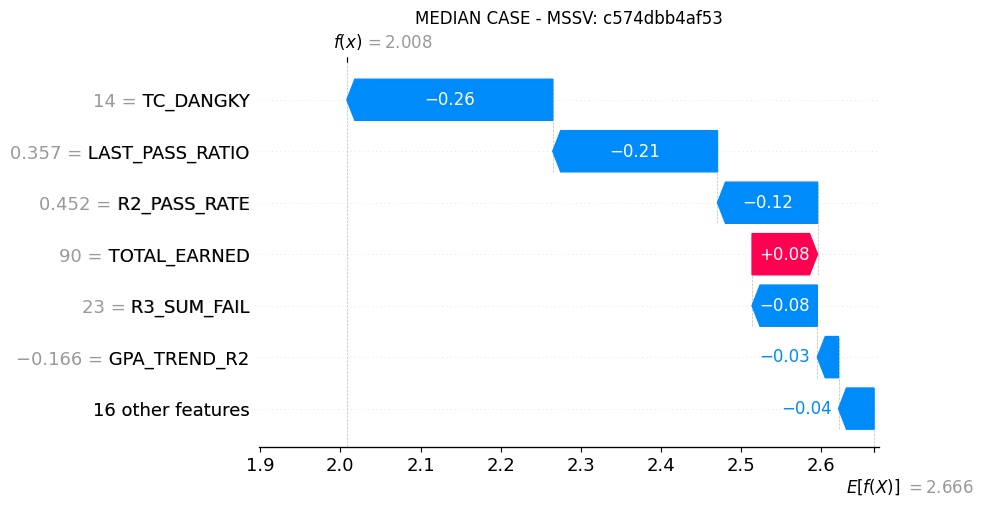


WORST CASE | MSSV: a70a3479f529 | True: 2.00 | Pred: 31.43


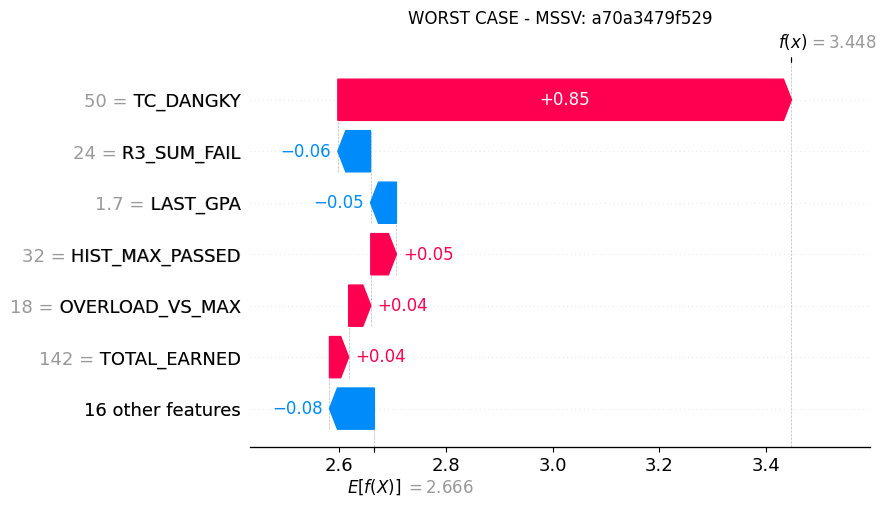


=== CONTRASTIVE ANALYSIS ===


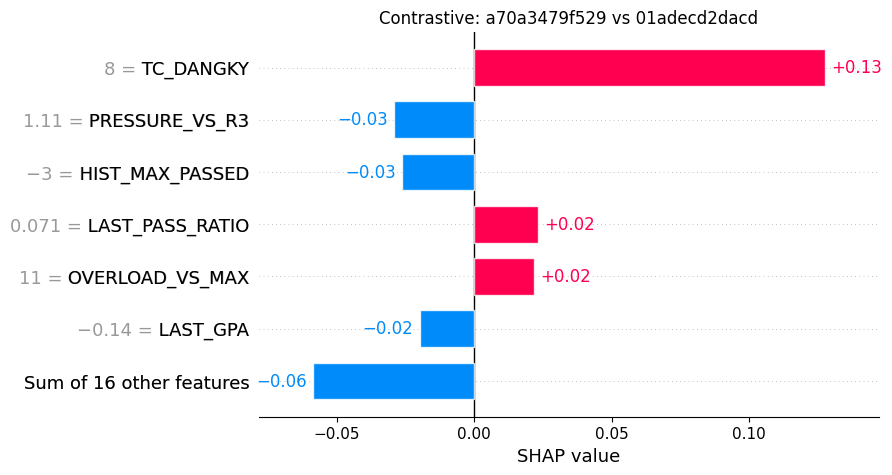

In [8]:
df_res_senior, exp_senior = SHAP(LGB_SENIOR, VAL_SENIOR, feats_senior)

In [9]:
def LIME(model_path, train_path, val_path, feats, target_col="TC_HOANTHANH", top_n=7):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    X_train = train_df[feats].values
    X_val = val_df[feats]
    y_true = val_df[target_col].values

    model = load_model(model_path)

    def predict_fn(data_numpy):
        if isinstance(model, lgb.Booster):
            return model.predict(data_numpy)
        return model.predict(data_numpy).flatten()

    y_pred = predict_fn(X_val.values)
    errors = np.abs(y_true - y_pred)
    
    idx_sorted = errors.argsort()
    n_total = len(val_df)
    case_indices = {
        "BEST CASE": idx_sorted[0],
        "MEDIAN CASE": idx_sorted[n_total // 2],
        "WORST CASE": idx_sorted[-1]
    }

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feats,
        class_names=[target_col],
        mode='regression'
    )

    print("\n=== LIME LOCAL EXPLANATIONS ===")
    for label, idx in case_indices.items():
        mssv = val_df.iloc[idx]['MA_SO_SV']
        print(f"\n{label} | MSSV: {mssv} | Error: {errors[idx]:.4f}")
        
        exp = explainer.explain_instance(
            data_row=X_val.values[idx], 
            predict_fn=predict_fn,
            num_features=top_n
        )
        
        fig = exp.as_pyplot_figure()
        plt.title(f"LIME: {label} (MSSV: {mssv})")
        plt.show()

    return errors

Load model: lgbm_fresher.txt

=== LIME LOCAL EXPLANATIONS ===

BEST CASE | MSSV: c531f1923c83 | Error: 0.0002


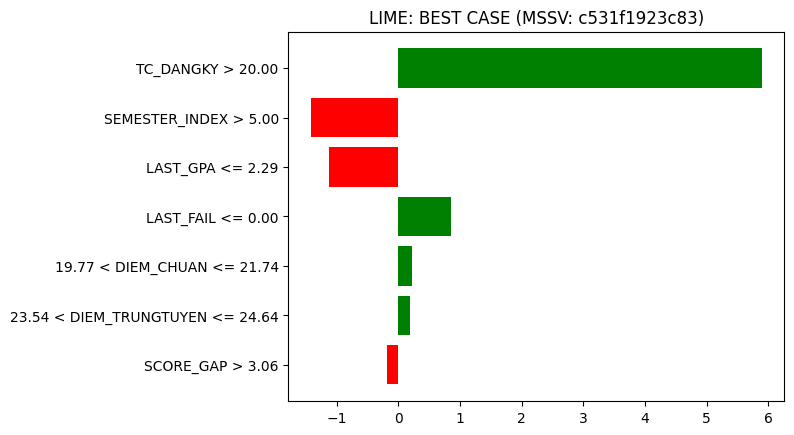


MEDIAN CASE | MSSV: f9d085ec1b49 | Error: 2.2037


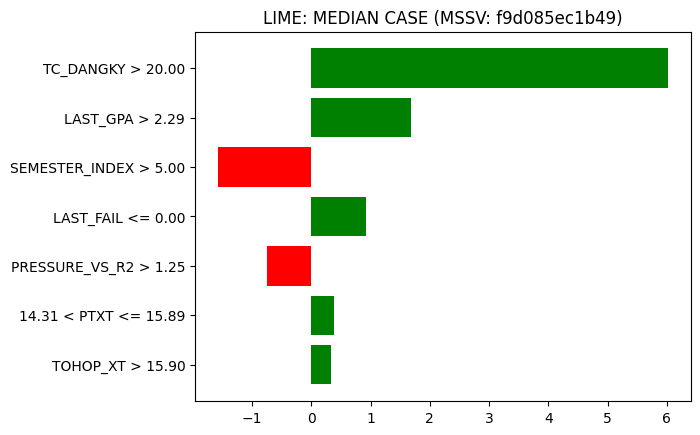


WORST CASE | MSSV: 88e963c787f7 | Error: 17.7593


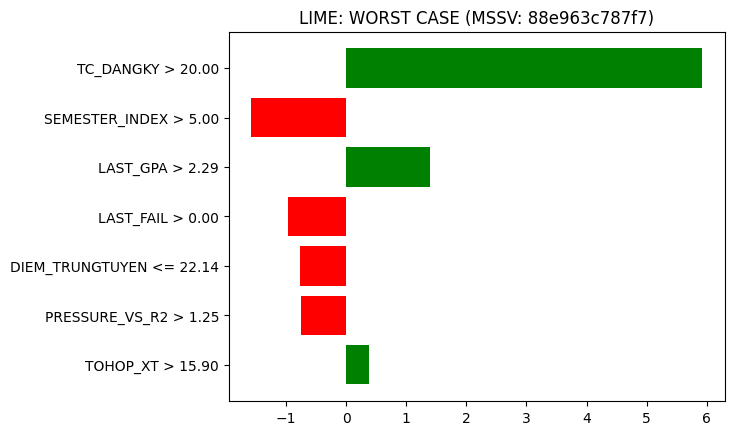

In [10]:
errors_fresh = LIME(LGB_FRESH, TRAIN_FRESH, VAL_FRESH, feats_fresh)

Load model: lgbm_senior.txt

=== LIME LOCAL EXPLANATIONS ===

BEST CASE | MSSV: cc925573751d | Error: 0.0003


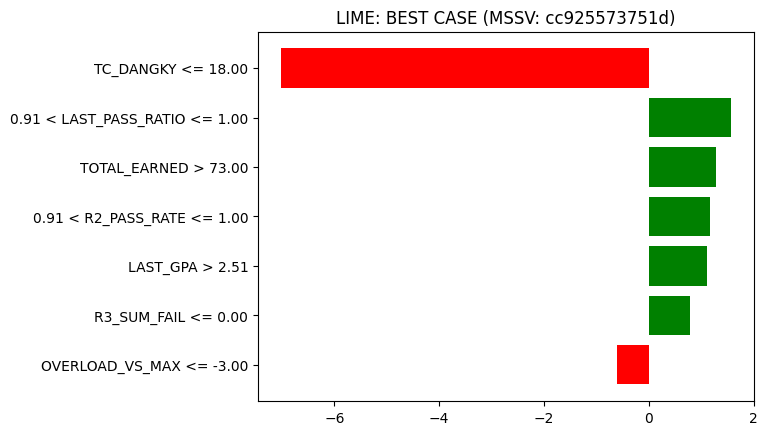


MEDIAN CASE | MSSV: c574dbb4af53 | Error: 1.4491


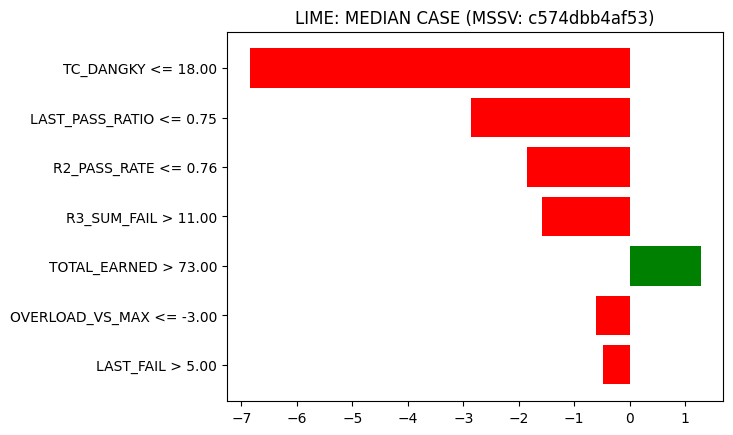


WORST CASE | MSSV: a70a3479f529 | Error: 29.4296


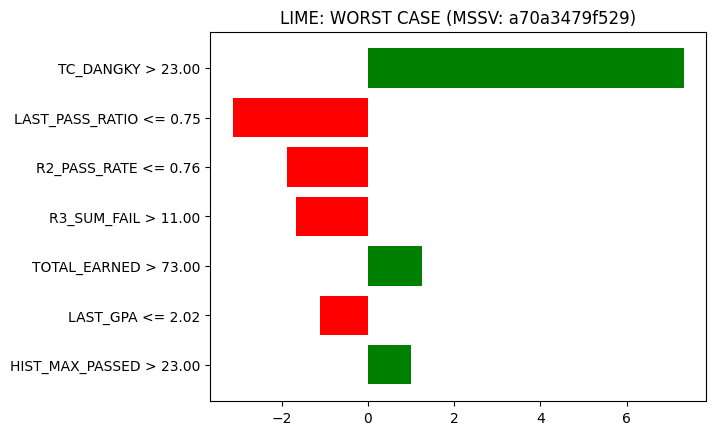

In [11]:
errors_senior = LIME(LGB_SENIOR, TRAIN_SENIOR, VAL_SENIOR, feats_senior)

In [12]:
def DICE(model_path, train_path, val_path, feats, target_col="TC_HOANTHANH", total_CFs=10):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    model = load_model(model_path)

    train_dice_df = train_df[feats + [target_col]].copy()
    train_dice_df[target_col] = train_dice_df[target_col].astype(float)
    
    d = dice_ml.Data(dataframe=train_dice_df, 
                     continuous_features=feats, 
                     outcome_name=target_col)
    
    m = dice_ml.Model(model=model, backend="sklearn", model_type="regressor")

    exp = dice_ml.Dice(d, m, method="random")

    X_val = val_df[feats]
    if isinstance(model, lgb.Booster):
        y_pred = model.predict(X_val)
    else:
        y_pred = model.predict(X_val).flatten()
        
    worst_idx = np.argmin(y_pred)
    mssv_worst = val_df.iloc[worst_idx]['MA_SO_SV']
    
    print(f"\n=== DICE COUNTERFACTUAL EXPLANATION ===")
    print(f"Tư vấn cho MSSV: {mssv_worst} | Dự báo hiện tại: {y_pred[worst_idx]:.4f}")

    query_instance = X_val.iloc[worst_idx:worst_idx+1]
    
    try:
        dice_exp = exp.generate_counterfactuals(
            query_instance, 
            total_CFs=total_CFs, 
            desired_range=[0.8, 1.0] 
        )
    except:
        dice_exp = exp.generate_counterfactuals(
            query_instance, 
            total_CFs=total_CFs, 
            desired_class="opposite"
        )

    dice_exp.visualize_as_dataframe(show_only_changes=True)

    return dice_exp

In [13]:
dice_exp_fresh = DICE(LGB_FRESH, TRAIN_FRESH, VAL_FRESH, feats_fresh)

Load model: lgbm_fresher.txt

=== DICE COUNTERFACTUAL EXPLANATION ===
Tư vấn cho MSSV: 56e51b523100 | Dự báo hiện tại: 0.2213


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Query instance (original outcome : 0.0)


,TC_DANGKY,SEMESTER_INDEX,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,SCORE_GAP,ENTRY_RANK,BENCHMARK_TIER,Z_SCORE,GAP_RATIO,LAST_GPA,LAST_FAIL,LAST_PASS_RATIO,PRESSURE_VS_R2,TC_HOANTHANH
0,2,7,14.375537,15.934068,24.379999,22.790001,1.59,0.799368,0.775088,1.165282,0.066835,0.0,13.0,0.0,0.0,0.0



Diverse Counterfactual set (new outcome: [0.8, 1.0])


,TC_DANGKY,SEMESTER_INDEX,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,SCORE_GAP,ENTRY_RANK,BENCHMARK_TIER,Z_SCORE,GAP_RATIO,LAST_GPA,LAST_FAIL,LAST_PASS_RATIO,PRESSURE_VS_R2,TC_HOANTHANH
0,-,-,-,-,-,-,2.4,-,-,-,-,-,-,0.7,-,0.8570975661277771
1,-,-,-,-,-,-,-,-,-,-,-,-,-,0.2,17.1,0.9618826508522034
2,-,-,-,-,-,-,2.1,-,-,-,-,-,-,0.7,-,0.8539257049560547
3,-,-,-,-,-,-,-,-,0.7795609,-,-,-,-,0.7,-,0.8541932702064514
4,-,-,-,-,-,-,-,-,-,-,0.4,-,-,0.7,-,0.8800111413002014
5,-,-,-,-,-,-,-,-,-,-,-,-,-,0.6,-,0.8001575469970703
6,-,-,-,-,-,-,-,-,-,-,-,-,2.1,-,5.6,0.8604969382286072
7,-,-,-,-,-,-,-,-,-,-,-,1.6885814,-,-,7.3,0.8623642325401306
8,-,-,-,13.608878,-,-,-,-,-,-,-,-,-,0.7,-,0.8683911561965942
9,-,-,-,-,-,-,-,-,-,-,-,-,-,0.7,-,0.8542973399162292


In [14]:
dice_exp_fresh = DICE(LGB_SENIOR, TRAIN_SENIOR, VAL_SENIOR, feats_senior)

Load model: lgbm_senior.txt

=== DICE COUNTERFACTUAL EXPLANATION ===
Tư vấn cho MSSV: c5ca672a4a35 | Dự báo hiện tại: 0.3072


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Query instance (original outcome : 0.0)


,TC_DANGKY,SEMESTER_INDEX,SV_NAM_THU,LAST_GPA,LAST_FAIL,LAST_PASS_RATIO,R2_AVG_GPA,R2_SUM_FAIL,R2_PASS_RATE,R3_AVG_GPA,...,OVERLOAD_R3,FAIL_TREND_R2,GPA_TREND_R2,TOTAL_EARNED,HIST_AVG_GPA,HIST_MAX_PASSED,HIST_MAX_GPA,HIST_STD_GPA,OVERLOAD_VS_MAX,TC_HOANTHANH
0,1,7,6,2.13,1.0,0.0,2.105,10.0,0.0,2.103333,...,-4.0,-4.0,-0.008333,79.0,2.113333,27.0,2.16,0.029439,-26.0,0.0



Diverse Counterfactual set (new outcome: [0.8, 1.0])


,TC_DANGKY,SEMESTER_INDEX,SV_NAM_THU,LAST_GPA,LAST_FAIL,LAST_PASS_RATIO,R2_AVG_GPA,R2_SUM_FAIL,R2_PASS_RATE,R3_AVG_GPA,...,OVERLOAD_R3,FAIL_TREND_R2,GPA_TREND_R2,TOTAL_EARNED,HIST_AVG_GPA,HIST_MAX_PASSED,HIST_MAX_GPA,HIST_STD_GPA,OVERLOAD_VS_MAX,TC_HOANTHANH
0,-,-,-,-,-,-,-,75.1,1.0,-,...,-,15.5,-,-,-,-,-,-,-,0.8730365633964539
1,-,-,-,-,43.3,-,-,-,1.0,-,...,-,9.4,-,-,-,-,-,-,-22.6,0.8556541204452515
2,-,-,-,-,-,-,-,-,1.1,-,...,-,-,-,169.8,1.9741079,-,-,-,-,0.8708959221839905
3,9.0,-,-,-,-,-,-,66.9,-,-,...,-,-,-,-,-,15.6,-,-,-,0.9135198593139648
4,-,-,-,-,-,-,-,77.6,0.6,-,...,-,-,-,-,2.5825683,-,-,-,-,0.8365882635116577
5,-,5.0,-,-,23.4,-,-,1.9,1.1,-,...,47.6,-,-,-,-,-,-,-,-,0.8095862865447998
6,-,-,-,-,22.6,-,-,-,0.7,2.5282495,...,-41.3,-,-,-,-,-,-,-,-,0.8001599907875061
7,-,-,-,-,-,-,-,-,1.1,-,...,-,-14.5,-,169.8,1.9741079,-,-,-,-,0.8724223375320435
8,9.0,-,-,2.3374022,-,-,-,66.9,-,-,...,-,-,-,-,-,15.6,-,-,-,0.9323199987411499
9,-,2.0,-,-,-,-,-,-,1.0,-,...,-,-,-,130.0,-,-,-,-,-,0.8536806106567383
